# DSCI 571: Supervised Machine Learning I 

## Lecture 3: $k$-nearest neighbours ($k$-NNs), support vector machines (SVMs) with RBF kernel

UBC Master of Data Science program, 2020-21

Instructor: Varada Kolhatkar

<blockquote>
If two things are similar, the thought of one will tend to trigger the thought of the other.
    
-- Aristotle 
</blockquote>


## Lecture learning objectives

From this lecture, you will be able to 

- explain the notion of similarity-based algorithms; 
- broadly describe how $k$-NNs use distances; 
- discuss the effect of using a small/large value of the hyperparameter $k$ when using the $k$-NN algorithm; 
- describe the problem of curse of dimensionality; 
- explain the general idea of SVMs with RBF kernel;
- explain the differences between $k$-NNs and SVM RBFs; 
- broadly describe the relation of `gamma` and `C` hyperparameters with the fundamental tradeoff.

### Lecture outline

1. [Motivation and terminology](#1)
2. [$k$-nearest neighbours](#2)
3. [SVMs with RBF](#4)

## Slide settings 

In [1]:
# And import the libraries

# pip install ipython-autotime
# import autotime
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from IPython.display import HTML

%pylab inline
# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

%matplotlib inline


pd.set_option("display.max_colwidth", 200)

Populating the interactive namespace from numpy and matplotlib


## 1. Motivation and terminology <a name="1"></a>

### Analogy-based models

- Suppose you are given the following training examples with corresponding labels and are asked to label a given test example.

<img src='./images/knn-motivation.png' width="1500">

[source](https://vipl.ict.ac.cn/en/database.php)

- An intuitive way to classify the test example is by finding the most "similar" example(s) from the training set and using that label for the test example.  

### Analogy-based algorithms in practice

- [Herta's High-tech Facial Recognition](https://www.hertasecurity.com/en)
    - Feature vectors for human faces 
    - $k$-NN to identify which face is on their watch list
- Recommendation systems     

### Terminology 

### Geometric view of tabular data and dimensions 

- To understand analogy-based algorithms it's useful to think of data as points in a high dimensional space. 
- Our `X` represents the the problem in terms of relevant **features** ($d$) with one dimension for each **feature** (column).
- Examples are **points in a $d$-dimensional space**. 

In [2]:
# How many dimensions (features) are there in the cities data? 
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
train_df.head()

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada


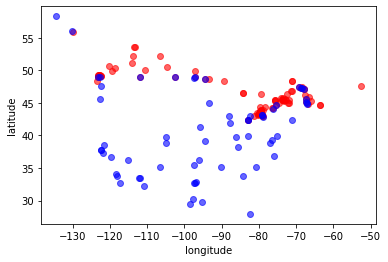

In [3]:
canada = train_df.query('country == "Canada"')
usa = train_df.query('country == "USA"')
plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.6)
plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.6)
plt.ylabel("latitude")
plt.xlabel("longitude");

### Dimensions

- Recall the [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset from Lab 1. 
- How many dimensions (features) we used in the lab? 

In [4]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
X = spotify_df.drop(columns=['target', 'song_title', 'artist'])
print("The number of features in the Spotify dataset: %d" % X.shape[1])
X.head()

The number of features in the Spotify dataset: 13


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904


### Dimensions in ML problems 

In ML, usually we deal with high dimensional problems where examples are hard to visualize.  

- $d \approx 20$ is considered low dimensional
- $d \approx 1000$ is considered medium dimensional 
- $d \approx 100,000$ is considered high dimensional 

### Feature vectors 

- Feature vector is a vector composed of feature values associated with an example.

In [5]:
print(
    "An example feature vector from the cities dataset: %s"
    % (train_df.drop(columns=["country"]).iloc[0].to_numpy())
)
print(
    "An example feature vector from the Spotify dataset: \n%s"
    % (X.iloc[0].to_numpy())
)

An example feature vector from the cities dataset: [-76.4813  44.2307]
An example feature vector from the Spotify dataset: 
[ 1.02000e-02  8.33000e-01  2.04600e+05  4.34000e-01  2.19000e-02
  2.00000e+00  1.65000e-01 -8.79500e+00  1.00000e+00  4.31000e-01
  1.50062e+02  4.00000e+00  2.86000e-01]


### Similarity between examples

In [6]:
# Let's take 2 points (two feature vectors) from the cities dataset.
two_cities = train_df.sample(2, random_state=42).drop(columns=["country"])
two_cities

,longitude,latitude
185,-71.3998,46.8884
14,-78.8784,42.8867


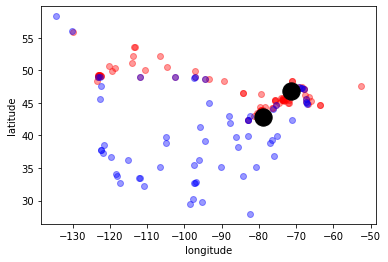

In [7]:
# The two sampled points are shown as big black circles.
plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.4)
plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.4)
plt.scatter(two_cities["longitude"], two_cities["latitude"], color="black", s=300)
plt.ylabel("latitude")
plt.xlabel("longitude");

### Distance between vectors 

- For the cities at the two big circles, what is the _distance_ between them?
- A common way to calculate the distance between vectors is calculating the **Euclidean distance**. 
- The euclidean distance between vectors $u = <u_1, u_2, \dots, u_n>$ and $v = <v_1, v_2, \dots, v_n>$ is defined as: 

$$distance(u, v) = \sqrt{\sum_{i =1}^{n} (u_i - v_i)^2}$$ 


### Euclidean distance 

In [8]:
two_cities

,longitude,latitude
185,-71.3998,46.8884
14,-78.8784,42.8867


- Subtract the two cities
- Square the difference
- Sum them up 
- Take the square root 

In [9]:
# Subtract the two cities
print("Subtract the cities: \n%s\n" % (two_cities.iloc[1] - two_cities.iloc[0]))

# Squared sum of the difference
print(
    "Sum of squares: %0.4f" % (np.sum((two_cities.iloc[1] - two_cities.iloc[0]) ** 2))
)

# Take the square root
print(
    "Euclidean distance between cities: %0.4f"
    % (np.sqrt(np.sum((two_cities.iloc[1] - two_cities.iloc[0]) ** 2)))
)

Subtract the cities: 
longitude   -7.4786
latitude    -4.0017
dtype: float64

Sum of squares: 71.9431
Euclidean distance between cities: 8.4819


In [10]:
two_cities

,longitude,latitude
185,-71.3998,46.8884
14,-78.8784,42.8867


In [11]:
# Euclidean distance using sklearn
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances(two_cities)

array([[0.        , 8.48192554],
       [8.48192554, 0.        ]])

Note: `scikit-learn` supports a number of other [distance metrics](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).


### Finding the nearest neighbour

- Let's look at distances from all cities to all other cities

In [12]:
dists = euclidean_distances(train_df[["latitude", "longitude"]])
np.fill_diagonal(dists, np.inf)
print("All distances: %s\n\n%s" % (dists.shape, dists))

All distances: (167, 167)

[[        inf  4.92866046 10.47586257 ... 45.36619339  3.13968038
   9.58476504]
 [ 4.92866046         inf 15.36399019 ... 40.48484175  1.80868018
  14.45684087]
 [10.47586257 15.36399019         inf ... 55.83947468 13.60621684
   0.94361393]
 ...
 [45.36619339 40.48484175 55.83947468 ...         inf 42.23325838
  54.93872568]
 [ 3.13968038  1.80868018 13.60621684 ... 42.23325838         inf
  12.70774745]
 [ 9.58476504 14.45684087  0.94361393 ... 54.93872568 12.70774745
          inf]]


Let's look at the distances between City 0 and some other cities. 

In [13]:
print("Feature vector for city 0: \n%s\n" %(train_df.iloc[0]))
print("Distances from city 0 to the first 5 cities: %s" % (dists[0][:5]))
# We can find the closest city with `np.argmin`:
print("The closest city from city 0 is: %d \n\nwith feature vector: \n%s" % (np.argmin(dists[0]), train_df.iloc[157]))

Feature vector for city 0: 
longitude   -76.4813
latitude     44.2307
country       Canada
Name: 160, dtype: object

Distances from city 0 to the first 5 cities: [        inf  4.92866046 10.47586257  3.40229467  9.04600003]
The closest city from city 0 is: 157 

with feature vector: 
longitude   -76.3019
latitude      44.211
country       Canada
Name: 96, dtype: object


Ok, so the closest city to City 0 is City 157. 

### Question

- Why did we set the diagonal entries to infinity before finding the closest city?

### Finding the distances to a query point

We can also find the distances to a new "test" or "query" city:

In [14]:
# Let's find a city that's closest to the a query city
query_point = [[-80, 25]]
dists = euclidean_distances(train_df[["longitude", "latitude"]], query_point)
dists[0:10]

array([[19.54996348],
       [18.02706204],
       [24.60912622],
       [21.39718237],
       [25.24111312],
       [47.81750619],
       [28.49499735],
       [19.39177482],
       [21.95316686],
       [19.01698738]])

In [15]:
# The query point is closest to
print(
    "The query point %s is closest to the city with index %d and the distance between them is: %0.4f"
    % (query_point, np.argmin(dists), dists[np.argmin(dists)])
)

The query point [[-80, 25]] is closest to the city with index 147 and the distance between them is: 3.8384


## 2. $k$-Nearest Neighbours ($k$-NNs) 

In [16]:
def plot_cities():
    plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.6)
    plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.6)
    plt.scatter(one_city["longitude"], one_city["latitude"], color="black", s=300)
    plt.ylabel("latitude")
    plt.xlabel("longitude")
    plt.legend(labels=["Canada", "USA"], loc=1)
    plt.grid(True)

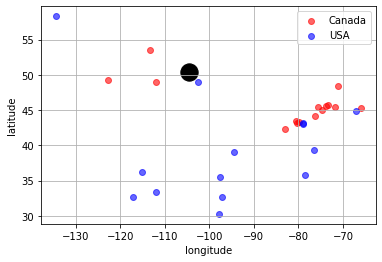

In [17]:
small_cities = cities_df.sample(30, random_state=90)
one_city = small_cities.sample(1, random_state=44)
small_train_df = pd.concat([small_cities, one_city]).drop_duplicates(keep=False)
canada = small_cities.query('country == "Canada"')
usa = small_cities.query('country == "USA"')
plot_cities()

Suppose we want to predict the class of the black point.  
- An intuitive way to do this is predict the same label as the "closest" point ($k = 1$) (1-nearest neighbour)
- We would predict a target of **USA** (blue) in this case.

How about using $k > 1$ to get a more robust estimate? 
- For example, we could also use the 3 closest points (*k* = 3) and let them **vote** on the correct class.  
- The **Canada** class (red) would win in this case. 

In [18]:
from sklearn.neighbors import KNeighborsClassifier

X_train = small_train_df.drop(columns=["country"])
y_train = small_train_df["country"]

k_values = [1, 3]

for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    print(
        "Prediction of the black dot with %d neighbours: %s"
        % (k, neigh.predict(one_city.drop(columns=["country"])))
    )

Prediction of the black dot with 1 neighbours: ['USA']
Prediction of the black dot with 3 neighbours: ['Canada']


### Questions

- Is it a good or a bad idea to consider an odd number for $k$? Why or why not? 
- Try different values of $k$ in the above code. 

### Choosing `n_neighbors`

- The primary hyperparameter of the model is `n_neighbors` ($k$) which decides how many neighbours should vote during prediction? 
- What happens when we play around with `n_neighbors`?
- Are we more likely to overfit with a low `n_neighbors` or a high `n_neighbors`?
- Let's examine the effect of the hyperparameter on our cities data. 

In [19]:
X = cities_df.drop(columns=["country"])
y = cities_df["country"]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123
)

In [20]:
k = 1
knn1 = KNeighborsClassifier(n_neighbors=k)
scores = cross_validate(knn1, 
                        X_train, 
                        y_train, 
                        return_train_score = True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002101,0.002770,0.710526,1.0
1,0.002034,0.003408,0.684211,1.0
2,0.001577,0.003395,0.842105,1.0
3,0.001521,0.002088,0.702703,1.0
4,0.001540,0.002073,0.837838,1.0


In [21]:
k = 100
knn100 = KNeighborsClassifier(n_neighbors=k)
scores = cross_validate(knn100, 
                        X_train, 
                        y_train, 
                        return_train_score = True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001525,0.002599,0.605263,0.600000
1,0.001982,0.003187,0.605263,0.600000
2,0.001869,0.003056,0.605263,0.600000
3,0.001719,0.003233,0.594595,0.602649
4,0.001794,0.003160,0.594595,0.602649


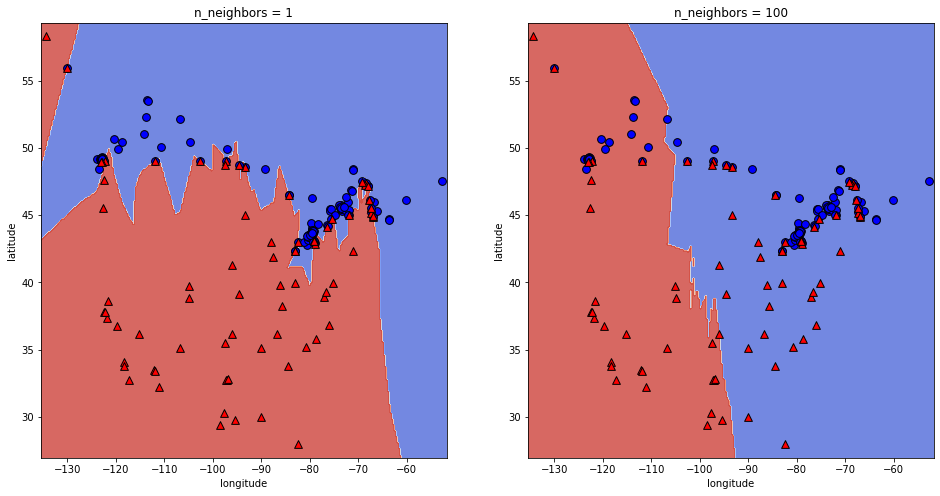

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
knn1.fit(X_train, y_train)
plt.title("n_neighbors = 1")
plot_classifier(X_train, y_train, knn1, ax=plt.gca(), ticks=True)
plt.ylabel("latitude")
plt.xlabel("longitude")

plt.subplot(1, 2, 2)
plt.title("n_neighbors = 100")
knn100.fit(X_train, y_train)
plot_classifier(X_train, y_train, knn100, ax=plt.gca(), ticks=True)
plt.ylabel("latitude")
plt.xlabel("longitude");

### How to choose `n_neighbors`?

- `n_neighbors` is a hyperparameter
- We can use hyperparameter optimization to choose `n_neighbors`.

In [23]:
results_dict = {"n_neighbors": [], "mean_train_score": [], "mean_cv_score": [], "std_cv_score" : [], "std_train_score":[]}
param_grid = {"n_neighbors": np.arange(1, 50, 5)}

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, 
                            X_train, 
                            y_train, 
                            return_train_score = True)
    results_dict["n_neighbors"].append(k)
        
    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)

In [24]:
results_df

,n_neighbors,mean_train_score,mean_cv_score,std_cv_score,std_train_score
0,1,1.000000,0.755477,0.069530,0.000000
1,6,0.831135,0.792603,0.046020,0.013433
2,11,0.819152,0.802987,0.041129,0.011336
3,16,0.801863,0.782219,0.074141,0.008735
4,21,0.777934,0.766430,0.062792,0.016944
5,26,0.755364,0.723613,0.061937,0.025910
6,31,0.743391,0.707681,0.057646,0.030408
7,36,0.728777,0.707681,0.064452,0.021305
8,41,0.706128,0.681223,0.061241,0.018310
9,46,0.694155,0.660171,0.093390,0.018178


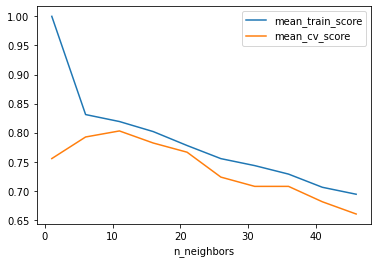

In [25]:
results_df = results_df.set_index("n_neighbors")
results_df[["mean_train_score", "mean_cv_score"]].plot()

In [26]:
sorted_results_df = results_df.sort_values("mean_cv_score", ascending = False)
sorted_results_df

,mean_train_score,mean_cv_score,std_cv_score,std_train_score
n_neighbors,,,,
11,0.819152,0.802987,0.041129,0.011336
6,0.831135,0.792603,0.046020,0.013433
16,0.801863,0.782219,0.074141,0.008735
21,0.777934,0.766430,0.062792,0.016944
1,1.000000,0.755477,0.069530,0.000000
26,0.755364,0.723613,0.061937,0.025910
31,0.743391,0.707681,0.057646,0.030408
36,0.728777,0.707681,0.064452,0.021305
41,0.706128,0.681223,0.061241,0.018310


In [27]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)
print("Test accuracy: %0.3f" %(knn.score(X_test, y_test)))

Test accuracy: 0.905


### Question for you

- Why do we have to treat $k$ as a hyperparameter rather than a parameter? 

### Other useful arguments of `KNeighborsClassifier`

- `weights` $\rightarrow$ When predicting label, you can assign higher weight to the examples which are closer to the query example.  
- Exercise for you: Play around with this argument. Do you get a better validation score? 

### Regression with $k$-nearest neighbours ($k$-NNs)

- Can we solve regression problems with $k$-nearest neighbours algorithm? 
- In $k$-NN regression we take the average of the $k$-nearest neighbours. 
- We can also have weighted regression. 

See an example of regression in the lecture notes. 

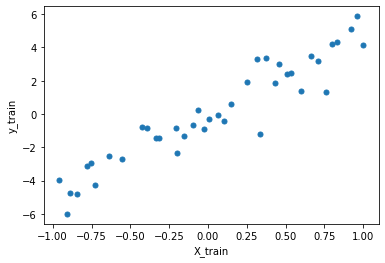

In [28]:
n = 50
X = np.linspace(-1,1,n)+np.random.randn(n)*0.01
X = X[:,None]
y = np.random.randn(n,1) + X*5
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
grid = np.linspace(min(X_train),max(X_train),1000)

plt.plot(X_train, y_train, '.', markersize=10);
plt.xlabel('X_train');
plt.ylabel('y_train');

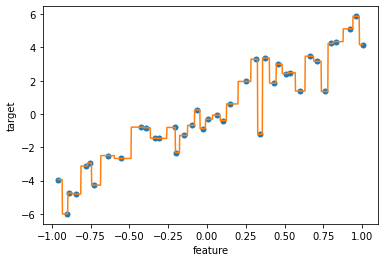

In [29]:
from sklearn.neighbors import KNeighborsRegressor

knnr = KNeighborsRegressor(n_neighbors=1, weights="uniform")
knnr.fit(X_train,y_train)
plt.plot(X_train,y_train,'.',markersize=10);
plt.plot(grid, knnr.predict(grid));
plt.xlabel("feature")
plt.ylabel("target");


### `score` method for regression 

In [30]:
knnr.score(
    X_train, y_train
)  # Returns the coefficient of determination R^2 of the prediction (not accuracy!)

1.0

And with $k=10$:

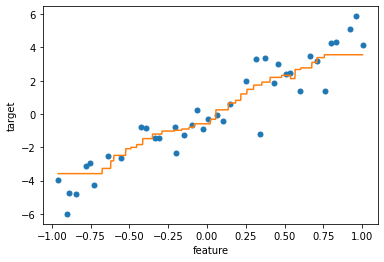

In [31]:
knnr = KNeighborsRegressor(n_neighbors=10, weights="uniform")
knnr.fit(X_train, y_train)
plt.plot(X_train,y_train,'.',markersize=10);
plt.plot(grid, knnr.predict(grid));
plt.xlabel("feature")
plt.ylabel("target");

In [32]:
knnr.score(X_train, y_train)

0.8687804301113358

### Using weighted distances

1.0

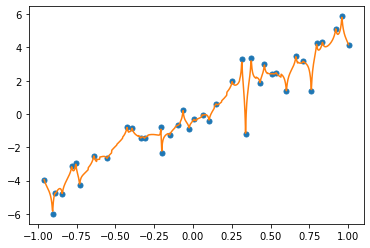

In [33]:
knnr = KNeighborsRegressor(n_neighbors=10, weights="distance")
knnr.fit(X_train, y_train);
plt.plot(X_train, y_train, ".", markersize=10)
plt.plot(grid, knnr.predict(grid));
knnr.score(X_train, y_train)

#### Summary of $k$-NN for supervised learning

Pros:

- Easy to understand, interpret.
- Simple hyperparameter $k$ (`n_neighbors`) controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.
- Lazy learning: Takes no time to `fit`

Cons:

- Can be potentially be VERY slow during prediction time. 
- Often not that great test accuracy compared to the modern approaches.

Note: for regular $k$-NN for supervised learning (not with sparse matrices), you should scale your features. We'll be looking into it in the next lecture. 

### Parametric vs non parametric 

- You might see a lot of definitions of these terms.
- A simple way to think about this is: 
    - do you need to store at least $O(n)$ worth of stuff to make predictions? If so, it's non-parametric.
- Non-parametric example: $k$-NN is a classic example of non-parametric models.     
- Parametric example: decision stump
- If you want to know more about this, find some reading material [here](https://www.cs.ubc.ca/~schmidtm/Courses/340-F16/L6.pdf), [here](http://mlss.tuebingen.mpg.de/2015/slides/ghahramani/gp-neural-nets15.pdf), and [here](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/). 
- By the way, the terms "parametric" and "non-paramteric" are often used differently by statisticians, see [here](https://help.xlstat.com/s/article/what-is-the-difference-between-a-parametric-and-a-nonparametric-test?language=en_US) for more...

### Curse of dimensionality

- Affects all learners but especially bad for nearest-neighbour. 
- $k$-NN usually works well when the number of dimensions $d$ is small but things fall apart quickly as $d$ goes up.
- If there are many irrelevant attributes, $k$-NN is hopelessly confused because all of them contribute to finding similarity between examples. 
- With enough irrelevant attributes the accidental similarity swamps out meaningful similarity and $k$-NN is no better than random guessing.  

In [34]:
from sklearn.datasets import make_classification

nfeats_accuracy = {'nfeats':[], 'dummy_valid_accuracy':[], 'KNN_valid_accuracy':[]}
for n_feats in range(4, 2000, 100):
    X, y = make_classification(n_samples=2000, 
                               n_features=n_feats, 
                               n_classes=2)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123
    )
    dummy = DummyClassifier(strategy = "most_frequent")
    dummy_scores = cross_validate(dummy, 
                            X_train, 
                            y_train, 
                            return_train_score = True)
    
    knn = KNeighborsClassifier()
    scores = cross_validate(knn, 
                            X_train, 
                            y_train, 
                            return_train_score = True)
    nfeats_accuracy['nfeats'].append(n_feats)
    nfeats_accuracy['KNN_valid_accuracy'].append(np.mean(scores['test_score']))
    nfeats_accuracy['dummy_valid_accuracy'].append(np.mean(dummy_scores['test_score']))    
    

In [35]:
pd.DataFrame(nfeats_accuracy)

,nfeats,dummy_valid_accuracy,KNN_valid_accuracy
0,4,0.499375,0.927500
1,104,0.511250,0.795000
2,204,0.505000,0.648125
3,304,0.511875,0.682500
4,404,0.504375,0.651250
5,504,0.501875,0.665625
6,604,0.503125,0.602500
7,704,0.504375,0.651250
8,804,0.513750,0.602500
9,904,0.510625,0.565625


### $k$-NN True/False questions

1. Unlike with decision trees, with $k$-NNs most of the work is done at the `predict` stage. 
2. With $k$-NN, setting the hyperparameter $k$ to larger values typically reduces training error. 
3. $k$-NN may perform poorly in high-dimensional space (say, *d* > 100). 
4. Similar to decision trees, $k$-NNs finds a small set of good features.

## 3. Support Vector Machines (SVMs) with RBF kernel 


- Very high-level overview
- Our goals here are
    - Use `scikit-learn`'s SVM model. 
    - Explain the similarities and differences between $k$-NNs and SVMs with RBF kernel
    - Explain the notion of support vectors
    - Explain how `C` and `gamma` hyperparameters control the fundamental tradeoff

- Another popular similarity-based algorithm is Support Vector Machines (SVM with RBFs)
- Superficially, SVMs are more like weighted $k$-NNs.
    - The decision boundary is defined by **a set of positive and negative examples** and **their weights** together with **their similarity measure**. 
    - A test example is a positive if on average it looks more like positive examples than the negative examples. 
- The primary difference between $k$-NNs and SVMs is that 
    - Unlike $k$-NNs, SVMs only remember the key examples (support vectors). So it's more efficient than $k$-NN. 
    - SVMs use a different similarity metric which is called a "kernel" in SVM land. A popular kernel is Radial Basis Functions (RBFs) (More on this in 573.)

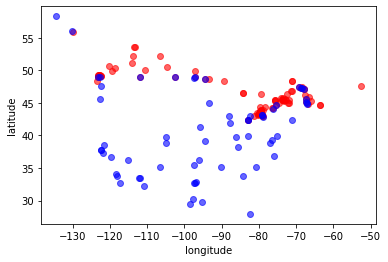

In [36]:
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
canada = train_df.query('country == "Canada"')
usa = train_df.query('country == "USA"')
plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.6)
plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.6)
plt.ylabel("latitude")
plt.xlabel("longitude");

In [37]:
# split into training/validation and testing set
X_train, y_train = train_df.drop(columns=['country']), train_df['country']
X_test, y_test = test_df.drop(columns=['country']), test_df['country']

In [38]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
scores = cross_validate(knn, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" %(np.mean(scores['test_score'])))
pd.DataFrame(scores)

Mean validation score 0.802


,fit_time,score_time,test_score,train_score
0,0.001515,0.002333,0.852941,0.849624
1,0.001640,0.002025,0.764706,0.834586
2,0.001379,0.001955,0.727273,0.850746
3,0.001373,0.001957,0.787879,0.858209
4,0.001370,0.001956,0.878788,0.813433


In [39]:
from sklearn.svm import SVC

svm = SVC(gamma=0.01) # Ignore gamma for now
svm.fit(X_train, y_train)
scores = cross_validate(svm, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" %(np.mean(scores['test_score'])))
pd.DataFrame(scores)

Mean validation score 0.820


,fit_time,score_time,test_score,train_score
0,0.002096,0.001098,0.823529,0.842105
1,0.001695,0.001066,0.823529,0.842105
2,0.001520,0.001052,0.727273,0.858209
3,0.001533,0.001052,0.787879,0.843284
4,0.001534,0.001055,0.939394,0.805970


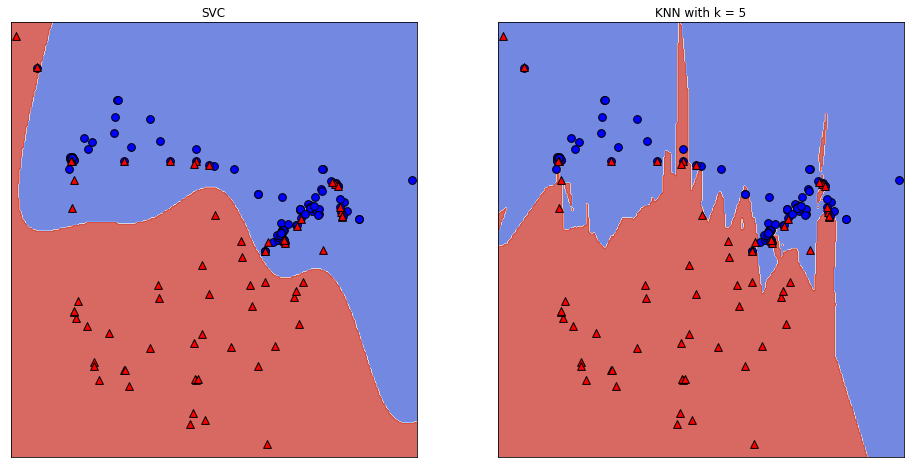

In [40]:
# You can think of SVM with RBF kernel as "smooth KNN"
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("SVC")
plot_classifier(X_train, y_train, svm, ax=plt.gca())
plt.subplot(1, 2, 2)
plt.title("KNN with k = 5")
plot_classifier(X_train, y_train, knn, ax=plt.gca())

In [41]:
print('KNN test score: %0.3f' %(knn.score(X_test, y_test)))
print('SVM test score: %0.3f' %(svm.score(X_test, y_test)))

KNN test score: 0.810
SVM test score: 0.833


#### Support vectors 

- Each training example either is or isn't a "support vector".
  - This gets decided during `fit`.

- **Main insight: the decision boundary only depends on the support vectors.**

- Let's look at the support vectors. 

In [42]:
from sklearn.datasets import make_blobs
# Let's generate some fake data
# generate blobs with fixed random generator
n = 20
n_classes = 2
X_toy, y_toy = make_blobs(n_samples=n, centers=n_classes, random_state=300)

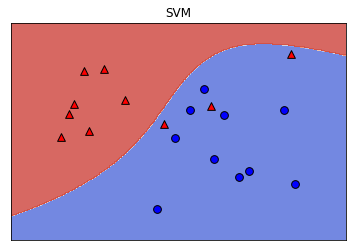

In [43]:
# Let's train an SVM classifier.
svm = SVC() 
svm.fit(X_toy, y_toy)
plt.title("SVM")
plot_classifier(X_toy, y_toy, svm, ax=plt.gca())

In [44]:
# How do we access support vectors
sv = svm.support_
not_sv = list(set(range(n)) - set(sv))
print("Support vectors: ", sv)
print("Non support vectors: ", not_sv)

Support vectors:  [ 3  8  9 14 18 19  0  1  4  6 15 16 17]
Non support vectors:  [2, 5, 7, 10, 11, 12, 13]


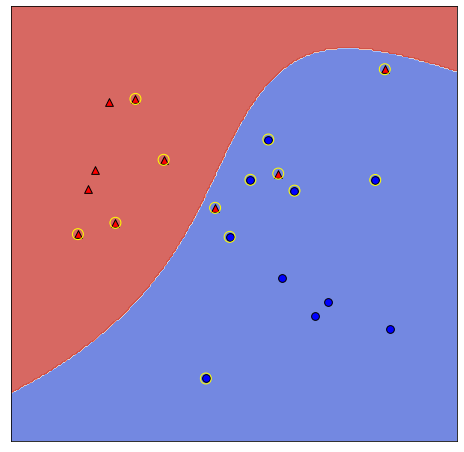

In [45]:
plt.figure(figsize=(8, 8))
plot_classifier(X_toy, y_toy, svm, ax=plt.gca())
plt.scatter(
    *svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120
)
# The support vectors (SVs) are shown in yellow.
# These are the example that "support" the boundary.

#### Support vectors

- Note that the number of support vectors is smaller compared to the training set. 
    - Makes a big difference on large datasets. 
- What happens if we delete all non-support vector? Would the decision boundary change? 
- What happens if we delete a support vector? Would the decision boundary change? 

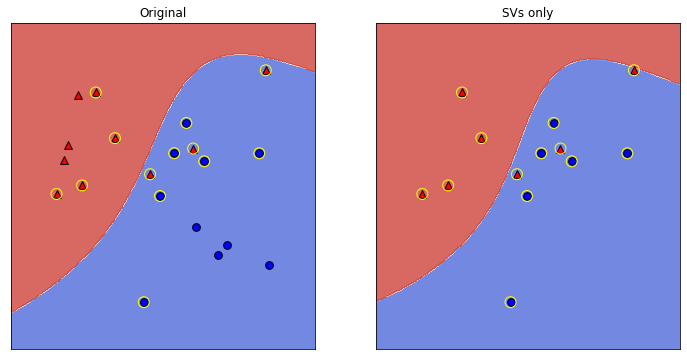

In [46]:
# Let's try removing all other examples, keeping only the SVs.
# remove all non-support vectors
X_only_SVs = np.delete(X_toy, not_sv, 0)
y_only_SVs = np.delete(y_toy, not_sv, 0)
svm_only_SVs = SVC()
svm_only_SVs.fit(X_only_SVs, y_only_SVs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_classifier(X_toy, y_toy, svm, ax=plt.gca())
plt.scatter(
    *svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120
)
plt.title("Original")

plt.subplot(1, 2, 2)
plot_classifier(X_only_SVs, y_only_SVs, svm_only_SVs, ax=plt.gca())
plt.scatter(
    *svm_only_SVs.support_vectors_.T,
    marker="o",
    edgecolor="yellow",
    facecolor="none",
    s=120
)
plt.title("SVs only");

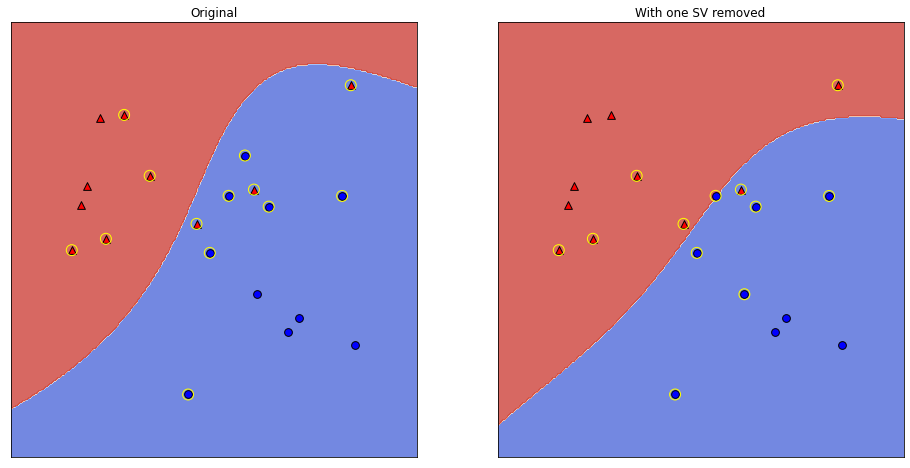

In [47]:
X_remove_SV = np.delete(X_toy, sv[1], 0)
y_remove_SV = np.delete(y_toy, sv[1], 0)

svm_remove_SV = SVC()
svm_remove_SV.fit(X_remove_SV, y_remove_SV)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_classifier(X_toy, y_toy, svm, ax=plt.gca())
plt.scatter(
    *svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120
)
plt.title("Original")

plt.subplot(1, 2, 2)
plot_classifier(X_remove_SV, y_remove_SV, svm_remove_SV, ax=plt.gca())
plt.scatter(
    *svm_remove_SV.support_vectors_.T,
    marker="o",
    edgecolor="yellow",
    facecolor="none",
    s=120
)
plt.title("With one SV removed");

### Hyperparameters of SVM 

- Key hyperparameters of `rbf` SVM are
    - `gamma`
    - `C`
    
- We are not equipped to understand the meaning of these parameters at this point but you are expected to describe their relation to the fundamental tradeoff. 

See [`scikit-learn`'s explanation of RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 

### Relation of `gamma` and the fundamental trade-off

- `gamma` controls the complexity (fundamental trade-off), just like other hyperparameters we've seen.
  - larger `gamma` $\rightarrow$ more complex
  - smaller `gamma` $\rightarrow$ less complex

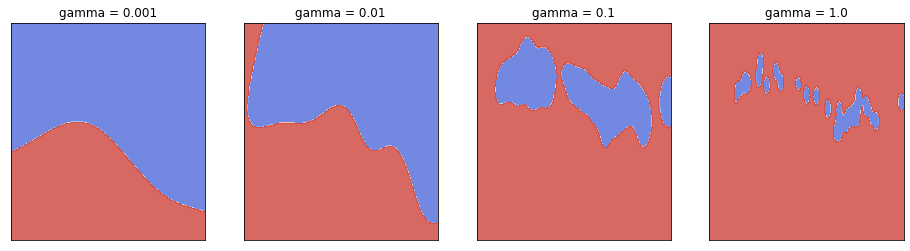

In [48]:
plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    gamma = 10.0 ** (i - 3)
    rbf_svm = SVC(gamma=gamma)
    rbf_svm.fit(X_train, y_train)
    plot_classifier(X_train, y_train, rbf_svm, ax=plt.gca(), show_data=False)
    plt.title("gamma = %s" % gamma);

### Relation of `C` and the fundamental trade-off

- `C` _also_ affects the fundamental tradeoff
    - larger `C` $\rightarrow$ more complex 
    - smaller `C` $\rightarrow$ less complex 

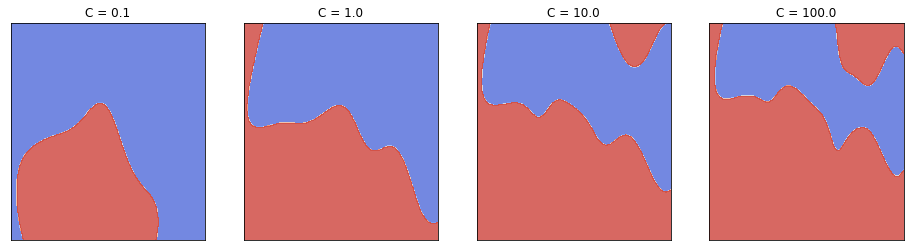

In [49]:
plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    C = 10.0 ** (i - 1)
    rbf_svm = SVC(C=C, gamma=0.01)
    rbf_svm.fit(X_train, y_train)
    plot_classifier(X_train, y_train, rbf_svm, ax=plt.gca(), show_data=False)
    plt.title("C = %s" % C);

### SVM RBF True/False questions

1. Similar to KNN, SVM with RBF kernel is a non-parametric model.
2. In SVM RBF, removing a non-support vector does not change the decision boundary. 
3. In sklearn’s SVC classifier, large values of gamma tend to result in higher training score but probably lower validation score. 

### Search over multiple hyperparameters

- So far you have seen how to carry out search over a hyperparameter
- In the above case the best training error is achieved by the most complex model (large `gamma`, large `C`).
- Best validation error requires a hyperparameter search to balance the fundamental tradeoff.
  - In general we can't search them one at a time.
  - More on this next week. But if you cannot wait till then, you may look up the following:
    - [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
    - [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

### More on RBF SVM and interpretation of `gamma` and `C` in 573! 

### SVM Regressor

- Similar to KNNs, you can use SVMs for regression problems as well.
- See [`sklearn.svm.SVR`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) for more details. 

### Summary

- We have KNNs and SVMs as new supervised learning techniques in our toolbox.
- These are analogy-based learners and the idea is to assign nearby points the same label.
- Unlike decision trees, all features are equally important. 
- Both can be used for classification or regression (much like the other methods we've seen).

## Revisit: Lecture learning objectives

From this lecture, you will be able to 

- explain the notion of similarity-based algorithms; 
- broadly describe how $k$-NNs use distances; 
- discuss the effect of using a small/large value of the hyperparameter $k$ when using the $k$-NN algorithm; 
- describe the problem of curse of dimensionality; 
- explain the general idea of SVMs with RBF kernel; 
- explain the differences between $k$-NNs and SVM RBFs;
- broadly describe the relation of `gamma` and `C` hyperparameters with the fundamental tradeoff.

### Questions for group discussion 

1. When we calculated Euclidean distances from all cities to all other cities, why did we set the diagonal entries to infinity before finding the closest city?
2. Why do we have to treat $k$ as a hyperparameter rather than a parameter? 
3. Which of the following models are parametric and which ones are non-parametric? 
    - Decision stumps
    - decision trees with no depth
    - KNNs
    - SVMs with RBF

### KNN practice question

Consider this toy dataset:

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

1. If $k=1$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$?
2. If $k=3$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$?
3. If $k=3$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$ if we were doing regression rather than classification?

In [50]:
### Varada's solution

X = pd.DataFrame({'feature1': [5, 4, 2, 10, 9, 9],
                  'feature2': [2, 3, 2, 10, -1, 9]})
y = [0, 0, 1, 1, 1, 2]

In [51]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X, y)
knn1.predict([[0,0]])

array([1])

In [52]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X, y)
knn3.predict([[0, 0]])

array([0])

In [53]:
knnr = KNeighborsRegressor(n_neighbors=3)
knnr.fit(X, y)
knnr.predict([[0,0]])

array([0.33333333])